## Target:

1. Recitfied Max pooling location from previous stage - only one max pool layer after RF 5
2. Add layers at the end after GAP layer
3. Add Regularization - Dropout and batch normalization
4. Make model lighter < 8k

## Results:
1. Parameters: 7,878
2. Best Training Accuracy: 99.09
3. Best Test Accuracy: 99.14

##Analysis:

1. No overfitting
2. Test accuarcay is oscillating at final epoch, adding LR schedular or Image Augumentation might help



In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [ ]:
train = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


torch.Size([128, 1, 28, 28])
torch.Size([128])


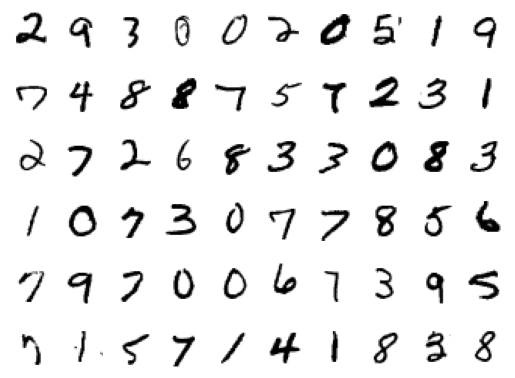

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 50, 3, stride=1, padding=1, bias=False),  #28>>28 | 1>>3 | 1>>1
            nn.ReLU(),
            nn.BatchNorm2d(50),
            nn.Dropout(0.05),
            nn.Conv2d(50, 10, 1, stride =1,padding=0, bias=False),  #28>>28 | 3>>3 | 1>>1
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05),
            nn.Conv2d(10, 10, 3, stride=1, padding=1, bias=False),#28>>28 | 3>>5 | 1>>1
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05)

        )
        # Transition Block 1
        self.trans1 = nn.Sequential(
            nn.MaxPool2d(2, 2),#28>>14 | 5>>6 | 1>>2
            #nn.Conv2d(16, 8, 1, stride=1, padding=0, bias=False),#14>>14 | 8>>8 | 2>>2
            #nn.ReLU(),
            #nn.BatchNorm2d(8),
            #nn.Dropout(0.05),

        )
        # Block 2
        self.conv2 = nn.Sequential(
            #nn.Conv2d(10, 8, 3, stride=1, padding=1, bias=False),#16>>16 | 8>>12 | 2>>2
            #nn.ReLU(),
            #nn.BatchNorm2d(8),
            #nn.Dropout(0.05),
            #nn.Conv2d(10, 10, 3, stride=1, padding=1, bias=False), #16>>16 | 12>>16 | 2>>2
            #nn.ReLU(),
            #nn.BatchNorm2d(10),
            #nn.Dropout(0.05),
            nn.Conv2d(10, 16, 3, stride=1, padding=1, bias=False),#16>>16 | 16>>20 | 2>>2
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
        )
        # Transition Block 2
        self.trans2 = nn.Sequential(
            #nn.MaxPool2d(2, 2),#16>>8 | 20>>22 | 2>>4
            nn.Conv2d(16, 8, 1, stride=1, bias=False),#8>>8 | 22>>22 | 4>>4
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.05),

        )

        # Block 4
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 8, 3, stride=1, padding=0, bias=False), #8>>8 | 22>>30 | 4>>4
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.05),
            nn.Conv2d(8, 16, 3, stride=1, padding=0, bias=False), #8>>8 | 22>>30 | 4>>4
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
            nn.Conv2d(16, 16, 3, stride=1, padding=0, bias=False), #8>>8 | 30>>38 | 4>>4
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),

        )

        self.fc = nn.Sequential(
            nn.Conv2d(16, 10, 1, stride=1, padding=0, bias=False), #8>>10 | 38>>42 | 4>>4
            #nn.ReLU(),
            #nn.BatchNorm2d(1),
            #nn.Dropout(0.05),
            #nn.Linear(10, 10)

        )
        self.gap = nn.Sequential(
            #nn.AvgPool2d(kernel_size=16) # ... nn.AdaptiveAvgPool((1, 1))
            nn.AdaptiveAvgPool2d((1, 1))
        ) # output_size = 1


    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = self.conv3(x)
        #x = self.norm4(x)
        #print('SIze', x.size)
        #x = x.view(-1, 3200)

        #x = x.view(x.size(0), -1)

        x = self.gap(x)
        x = self.fc(x)
        #x = self.gpool(x)
        x = x.view(-1, 10)
        #x = F.relu(self.fc1(x))
        #x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 50, 28, 28]             450
              ReLU-2           [-1, 50, 28, 28]               0
       BatchNorm2d-3           [-1, 50, 28, 28]             100
           Dropout-4           [-1, 50, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             500
              ReLU-6           [-1, 10, 28, 28]               0
       BatchNorm2d-7           [-1, 10, 28, 28]              20
           Dropout-8           [-1, 10, 28, 28]               0
            Conv2d-9           [-1, 10, 28, 28]             900
             ReLU-10           [-1, 10, 28, 28]               0
      BatchNorm2d-11           [-1, 10, 28, 28]              20
          Dropout-12           [-1, 10, 28, 28]               0
        MaxPool2d-13           [-1, 10, 14, 14]               0
           Conv2d-14           [-1, 16,

In [ ]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)
    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 15
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Epoch 1


Loss=0.21688304841518402 Batch_id=468 Accuracy=81.42: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]



Test set: Average loss: 0.1322, Accuracy: 9662/10000 (96.62%)

Epoch 2


Loss=0.07005687803030014 Batch_id=468 Accuracy=96.93: 100%|██████████| 469/469 [00:18<00:00, 25.35it/s]



Test set: Average loss: 0.0832, Accuracy: 9756/10000 (97.56%)

Epoch 3


Loss=0.049663543701171875 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:18<00:00, 25.45it/s]



Test set: Average loss: 0.0528, Accuracy: 9848/10000 (98.48%)

Epoch 4


Loss=0.06319855153560638 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:19<00:00, 23.87it/s]



Test set: Average loss: 0.0514, Accuracy: 9838/10000 (98.38%)

Epoch 5


Loss=0.044727399945259094 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:19<00:00, 24.40it/s]



Test set: Average loss: 0.0407, Accuracy: 9872/10000 (98.72%)

Epoch 6


Loss=0.006399780977517366 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:21<00:00, 21.91it/s]



Test set: Average loss: 0.0368, Accuracy: 9891/10000 (98.91%)

Epoch 7


Loss=0.07510039210319519 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:18<00:00, 25.57it/s]



Test set: Average loss: 0.0356, Accuracy: 9888/10000 (98.88%)

Epoch 8


Loss=0.03277061507105827 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]



Test set: Average loss: 0.0334, Accuracy: 9897/10000 (98.97%)

Epoch 9


Loss=0.05696197971701622 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:19<00:00, 24.23it/s]



Test set: Average loss: 0.0333, Accuracy: 9884/10000 (98.84%)

Epoch 10


Loss=0.02216639555990696 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:19<00:00, 24.67it/s]



Test set: Average loss: 0.0321, Accuracy: 9896/10000 (98.96%)

Epoch 11


Loss=0.009229081682860851 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:20<00:00, 23.10it/s]



Test set: Average loss: 0.0269, Accuracy: 9911/10000 (99.11%)

Epoch 12


Loss=0.02433980070054531 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:18<00:00, 24.70it/s]



Test set: Average loss: 0.0250, Accuracy: 9919/10000 (99.19%)

Epoch 13


Loss=0.052793364971876144 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:19<00:00, 24.45it/s]



Test set: Average loss: 0.0260, Accuracy: 9919/10000 (99.19%)

Epoch 14


Loss=0.013085772283375263 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:18<00:00, 25.75it/s]



Test set: Average loss: 0.0260, Accuracy: 9914/10000 (99.14%)

Epoch 15


Loss=0.016348062083125114 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:20<00:00, 23.35it/s]



Test set: Average loss: 0.0271, Accuracy: 9910/10000 (99.10%)



Text(0.5, 1.0, 'Test Accuracy')

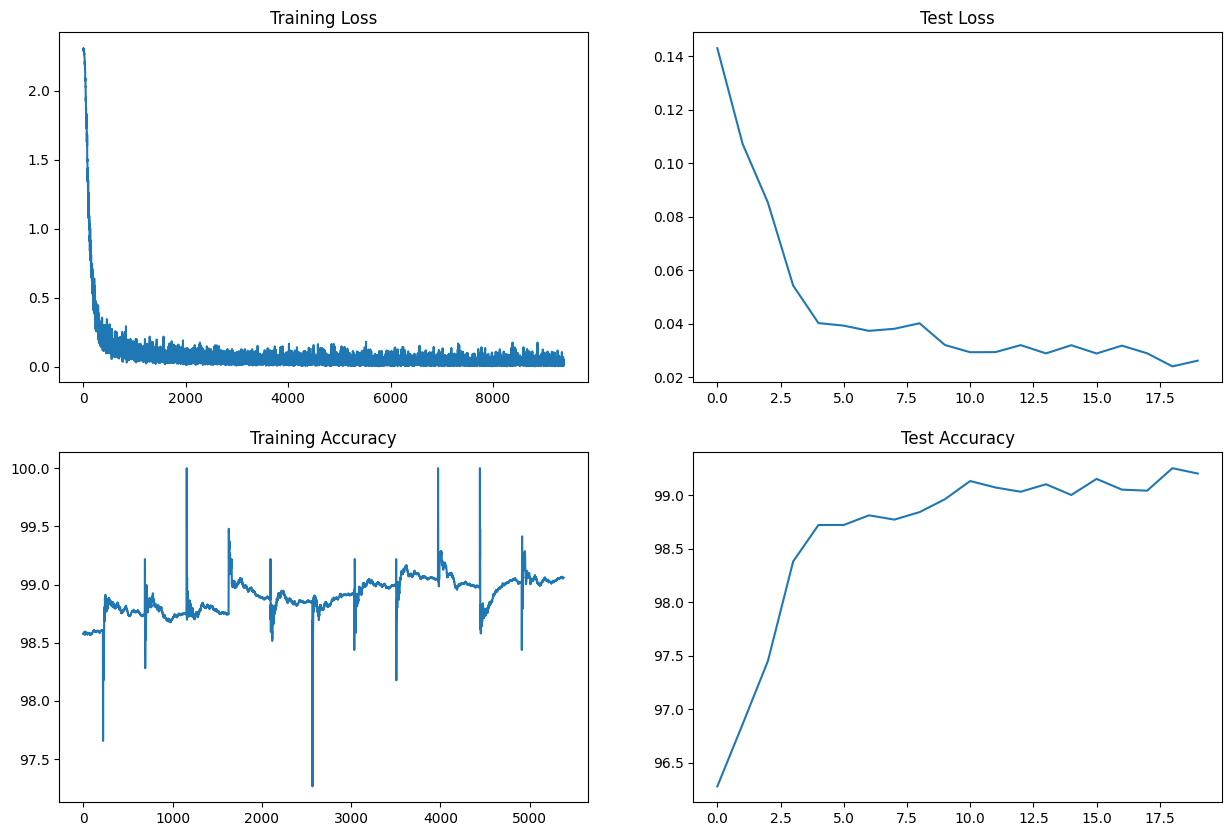

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")